<a id='top'></a>
# Searching for high-redshift galaxies in CEERS
---

Opening and plotting CEERS images and catalogs.

## Table of Contents
* [Imports](#imports)
* [Displaying Images](#images)
* [Making Color-Color Plots](#phot)
* [Plotting P(z) and Chi^2](#pz)
* [Printing EAZY Results for Sample](#results)

<a id='imports'></a>
## Imports

In [1]:
import os
from glob import glob
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.visualization import ImageNormalize, ZScaleInterval

Set up matplotlib for plotting

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use this version for non-interactive plots (easier scrolling of the notebook)
#%matplotlib inline

# Use this version if you want interactive plots
%matplotlib notebook
#%matplotlib inline

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
#%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# You may want to change the following configurations to customize 
# figure sizes and resolutions
rcParams['figure.figsize'] = [8,6]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 80

Create a function for quickly displaying the images

In [3]:
def plot_images(images, nrows=2):
    """Display images side-by-side for comparison. 
    
    Will plot a grid of figures that is (nrows x ncols), where
    ncols is determined by how many images are in the list
    and the number of rows specified.

    Args:
        images (str): list of image filenames for plotting 
        nrows (Optional [int]): number of rows in grid 
    """
    # determine how many columns are needed
    ncols = int(np.ceil(len(images) / nrows))
    fig,axes = plt.subplots(nrows, ncols, tight_layout=True)
    axs = axes.flatten()

    for i,image in enumerate(images):
        # normalize with zscale
        im = fits.getdata(image)
        norm = ImageNormalize(im, interval=ZScaleInterval())
        axs[i].imshow(im, origin='lower', interpolation='none', cmap='Greys', norm=norm)
  
        # turn off axes ticks
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

        axs[i].set_title(os.path.basename(image), fontsize=10)
        
    # turn off empty axes entirely
    nblank = nrows * ncols - len(images)
    for i in range(nblank):
        axs[-(i+1)].axis('off')

In [4]:
def plot_image(image):
    """Display an image with a zscale normalization 

    Args:
        image (str): filename of image for visualization
    """
    fig,ax = plt.subplots(1, 1, tight_layout=True)


    im = fits.getdata(image)
    norm = ImageNormalize(im, interval=ZScaleInterval())
    ax.imshow(im, origin='lower', interpolation='none', cmap='Greys', norm=norm)
  
    # turn off axes ticks
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.set_title(os.path.basename(image), fontsize=10)

<a id='images'></a>
## Displaying Images

In [5]:
# Get a list of all images
images = glob('/media/home/team_workspaces/JWST-Heidelberg-Summer-School/Lecturers_Area/09_Friday_Session_3/data/ceers_nrc_*sci.fits')
images.sort()

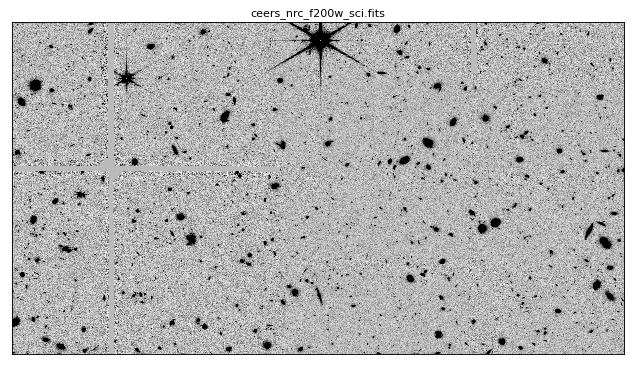

In [6]:
# Plot a single image
%matplotlib inline
plot_image(images[2])

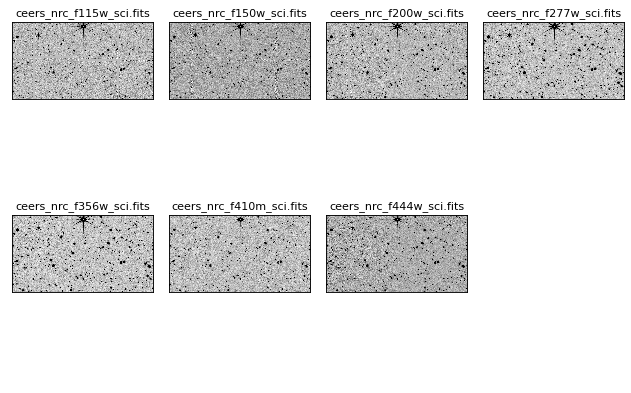

In [7]:
# Plot all images in a grid
%matplotlib inline
plot_images(images)

[Return to Top](#top)

<a id='phot'></a>
## Making Color-Color Plots

In [10]:
# Read in photometry catalog
phot = Table.read('/media/home/team_workspaces/JWST-Heidelberg-Summer-School/Lecturers_Area/09_Friday_Session_3/catalogs/ceers_photom_0.1.fits')
phot

ID,COORDID,RA,DEC,X,Y,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_IMAGE,APCORR,APCORR_APER,APCORR_WINGS,STELLARITY,ISOAREA_IMAGE,D_APER,FLUX_F606W,FLUXERR_F606W,FLUX_APER_F606W,FLUX_APER_NATIVE_F606W,FLUXERR_APER_F606W,FLUX_APERTOT_F606W,FLUXERR_APERTOT_F606W,RH_F606W,FWHM_F606W,FLUXERR_LOCAL_D0P2_F606W,FLUXERR_LOCAL_D0P3_F606W,FLUXERR_LOCAL_D0P4_F606W,FLUXERR_LOCAL_D0P5_F606W,FLUX_F814W,FLUXERR_F814W,FLUX_APER_F814W,FLUX_APER_NATIVE_F814W,FLUXERR_APER_F814W,FLUX_APERTOT_F814W,FLUXERR_APERTOT_F814W,RH_F814W,FWHM_F814W,FLUXERR_LOCAL_D0P2_F814W,FLUXERR_LOCAL_D0P3_F814W,FLUXERR_LOCAL_D0P4_F814W,FLUXERR_LOCAL_D0P5_F814W,FLUX_F125W,FLUXERR_F125W,FLUX_APER_F125W,FLUX_APER_NATIVE_F125W,FLUXERR_APER_F125W,FLUX_APERTOT_F125W,FLUXERR_APERTOT_F125W,RH_F125W,FWHM_F125W,FLUXERR_LOCAL_D0P2_F125W,FLUXERR_LOCAL_D0P3_F125W,FLUXERR_LOCAL_D0P4_F125W,FLUXERR_LOCAL_D0P5_F125W,FLUX_F140W,FLUXERR_F140W,FLUX_APER_F140W,FLUX_APER_NATIVE_F140W,FLUXERR_APER_F140W,FLUX_APERTOT_F140W,FLUXERR_APERTOT_F140W,RH_F140W,FWHM_F140W,FLUXERR_LOCAL_D0P2_F140W,FLUXERR_LOCAL_D0P3_F140W,FLUXERR_LOCAL_D0P4_F140W,FLUXERR_LOCAL_D0P5_F140W,FLUX_F160W,FLUXERR_F160W,FLUX_APER_F160W,FLUX_APER_NATIVE_F160W,FLUXERR_APER_F160W,FLUX_APERTOT_F160W,FLUXERR_APERTOT_F160W,RH_F160W,FWHM_F160W,FLUXERR_LOCAL_D0P2_F160W,FLUXERR_LOCAL_D0P3_F160W,FLUXERR_LOCAL_D0P4_F160W,FLUXERR_LOCAL_D0P5_F160W,FLUX_F115W,FLUXERR_F115W,FLUX_APER_F115W,FLUX_APER_NATIVE_F115W,FLUXERR_APER_F115W,FLUX_APERTOT_F115W,FLUXERR_APERTOT_F115W,RH_F115W,FWHM_F115W,FLUXERR_LOCAL_D0P2_F115W,FLUXERR_LOCAL_D0P3_F115W,FLUXERR_LOCAL_D0P4_F115W,FLUXERR_LOCAL_D0P5_F115W,FLUX_F150W,FLUXERR_F150W,FLUX_APER_F150W,FLUX_APER_NATIVE_F150W,FLUXERR_APER_F150W,FLUX_APERTOT_F150W,FLUXERR_APERTOT_F150W,RH_F150W,FWHM_F150W,FLUXERR_LOCAL_D0P2_F150W,FLUXERR_LOCAL_D0P3_F150W,FLUXERR_LOCAL_D0P4_F150W,FLUXERR_LOCAL_D0P5_F150W,FLUX_F200W,FLUXERR_F200W,FLUX_APER_F200W,FLUX_APER_NATIVE_F200W,FLUXERR_APER_F200W,FLUX_APERTOT_F200W,FLUXERR_APERTOT_F200W,RH_F200W,FWHM_F200W,FLUXERR_LOCAL_D0P2_F200W,FLUXERR_LOCAL_D0P3_F200W,FLUXERR_LOCAL_D0P4_F200W,FLUXERR_LOCAL_D0P5_F200W,FLUX_F277W,FLUXERR_F277W,FLUX_APER_F277W,FLUX_APER_NATIVE_F277W,FLUXERR_APER_F277W,FLUX_APERTOT_F277W,FLUXERR_APERTOT_F277W,RH_F277W,FWHM_F277W,FLUXERR_LOCAL_D0P2_F277W,FLUXERR_LOCAL_D0P3_F277W,FLUXERR_LOCAL_D0P4_F277W,FLUXERR_LOCAL_D0P5_F277W,FLUX_F356W,FLUXERR_F356W,FLUX_APER_F356W,FLUX_APER_NATIVE_F356W,FLUXERR_APER_F356W,FLUX_APERTOT_F356W,FLUXERR_APERTOT_F356W,RH_F356W,FWHM_F356W,FLUXERR_LOCAL_D0P2_F356W,FLUXERR_LOCAL_D0P3_F356W,FLUXERR_LOCAL_D0P4_F356W,FLUXERR_LOCAL_D0P5_F356W,FLUX_F410M,FLUXERR_F410M,FLUX_APER_F410M,FLUX_APER_NATIVE_F410M,FLUXERR_APER_F410M,FLUX_APERTOT_F410M,FLUXERR_APERTOT_F410M,RH_F410M,FWHM_F410M,FLUXERR_LOCAL_D0P2_F410M,FLUXERR_LOCAL_D0P3_F410M,FLUXERR_LOCAL_D0P4_F410M,FLUXERR_LOCAL_D0P5_F410M,FLUX_F444W,FLUXERR_F444W,FLUX_APER_F444W,FLUX_APER_NATIVE_F444W,FLUXERR_APER_F444W,FLUX_APERTOT_F444W,FLUXERR_APERTOT_F444W,RH_F444W,FWHM_F444W,FLUXERR_LOCAL_D0P2_F444W,FLUXERR_LOCAL_D0P3_F444W,FLUXERR_LOCAL_D0P4_F444W,FLUXERR_LOCAL_D0P5_F444W
int32,bytes21,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64[12],float64,float32,float32,float64[12],float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],float64[12],float32,float32,float64,float64,float64,float64,float64,float64,float64[12],float64[12],float64[12],float64[12],floa

Make a color-color plot using the fiducial fluxes in the catalog

In [11]:
def plot_color_color(filt1, filt2, filt3, cat, ploterrors=False):
    """Create a color-color plot for the provided filters.
    
    Plot will be [filt1]-[filt2] (yaxis) vs. [filt2]-[filt3] (xaxis)
    
    Uses the fiducial fluxes in the catalog ('FLUX_F*', 'FLUXERR_F*')
    
    Args:
        filt1 (str): first filter to use in the color-color plot
        filt2 (str): second filter to use in the color-color plot
        filt3 (str): third filter to use in the color-color plot
        cat (astropy.table): table of photometry
        ploterrors (Optional [bool]): Set to True to include errorbars
    """
    flux1 = cat[f'FLUX_{filt1}']
    flux2 = cat[f'FLUX_{filt2}']
    flux3 = cat[f'FLUX_{filt3}']
    
    # Convert fluxes to magnitudes
    mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
    mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
    mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
    color1 = mag1 - mag2
    color2 = mag2 - mag3
    
    fig,ax = plt.subplots(1, 1, tight_layout=True)
    if ploterrors:
        err1 = 2.5/np.log(10) * phot[f'FLUXERR_{filt1}']/flux1
        err2 = 2.5/np.log(10) * phot[f'FLUXERR_{filt2}']/flux2
        err3 = 2.5/np.log(10) * phot[f'FLUXERR_{filt3}']/flux3
        ecolor1 = np.sqrt(err1**2 + err2**2)
        ecolor2 = np.sqrt(err2**2 + err3**2)
        ax.errorbar(color2, color1, xerr=ecolor2, yerr=ecolor1, fmt='.', color='C0', alpha=0.5)
    else:
        ax.scatter(color2, color1, marker='.', color='C0', alpha=0.5)
    ax.set_xlabel(f'{filt2}-{filt3}')
    ax.set_ylabel(f'{filt1}-{filt2}')


/tmp/ipykernel_846/799481906.py:20: RuntimeWarning: divide by zero encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:20: RuntimeWarning: invalid value encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:21: RuntimeWarning: divide by zero encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:21: RuntimeWarning: invalid value encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:22: RuntimeWarning: divide by zero encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:22: RuntimeWarning: invalid value encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:23: RuntimeWarning: invalid value encountered in subtract
  color1 = mag1 - mag2
/tmp/ipykernel_846/799481906.py:24: RuntimeWarning: invalid value encountered in subtract
  color2 = mag2 - ma

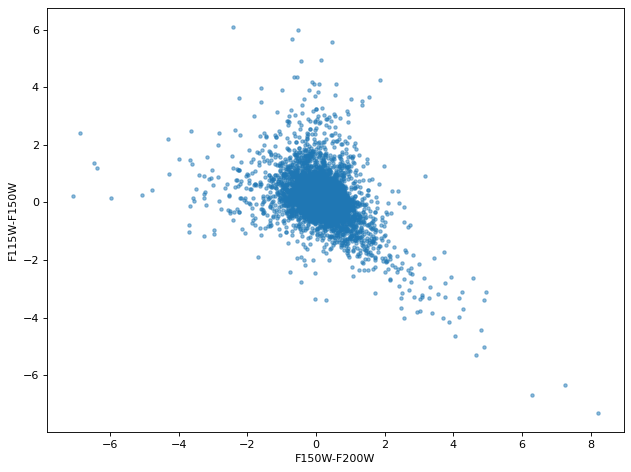

In [31]:
# Plot the F115W-F150W, F150W-F200W for the full catalog
%matplotlib inline
plot_color_color('F115W', 'F150W', 'F200W', phot)

/tmp/ipykernel_846/799481906.py:20: RuntimeWarning: divide by zero encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:20: RuntimeWarning: invalid value encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:21: RuntimeWarning: divide by zero encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:21: RuntimeWarning: invalid value encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:22: RuntimeWarning: divide by zero encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:22: RuntimeWarning: invalid value encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/799481906.py:23: RuntimeWarning: invalid value encountered in subtract
  color1 = mag1 - mag2
/tmp/ipykernel_846/799481906.py:24: RuntimeWarning: invalid value encountered in subtract
  color2 = mag2 - ma

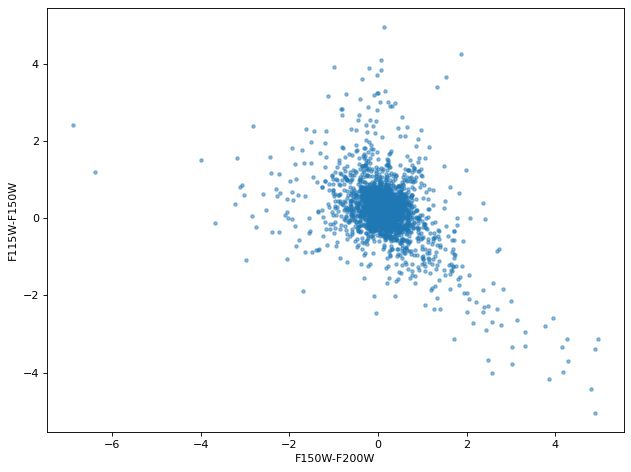

In [32]:
# Plot the F115W-F150W, F150W-F200W for a subset of the full catalog
# For example, all sources with stellarity < 0.5
w = np.where(phot['STELLARITY'] < 0.5)
plot_color_color('F115W', 'F150W', 'F200W', phot[w])

Read in one of the provided model tracks

In [36]:
#Define new plotting code to accept track curves
def plot_color_color_tracks(filt1, filt2, filt3, cat, track_colx, track_coly, ploterrors=False):
    """Create a color-color plot for the provided filters.
    
    Plot will be [filt1]-[filt2] (yaxis) vs. [filt2]-[filt3] (xaxis)
    
    Uses the fiducial fluxes in the catalog ('FLUX_F*', 'FLUXERR_F*')
    
    Args:
        filt1 (str): first filter to use in the color-color plot
        filt2 (str): second filter to use in the color-color plot
        filt3 (str): third filter to use in the color-color plot
        cat (astropy.table): table of photometry
        ploterrors (Optional [bool]): Set to True to include errorbars
    """
    flux1 = cat[f'FLUX_{filt1}']
    flux2 = cat[f'FLUX_{filt2}']
    flux3 = cat[f'FLUX_{filt3}']
    
    # Convert fluxes to magnitudes
    mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
    mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
    mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
    color1 = mag1 - mag2
    color2 = mag2 - mag3
    
    fig,ax = plt.subplots(1, 1, tight_layout=True)
    if ploterrors:
        err1 = 2.5/np.log(10) * phot[f'FLUXERR_{filt1}']/flux1
        err2 = 2.5/np.log(10) * phot[f'FLUXERR_{filt2}']/flux2
        err3 = 2.5/np.log(10) * phot[f'FLUXERR_{filt3}']/flux3
        ecolor1 = np.sqrt(err1**2 + err2**2)
        ecolor2 = np.sqrt(err2**2 + err3**2)
        ax.errorbar(color2, color1, xerr=ecolor2, yerr=ecolor1, fmt='.', color='C0', alpha=0.5)
    else:
        ax.scatter(color2, color1, marker='.', color='C0', alpha=0.5)
        
    ax.plot(track_colx,track_coly,color='red')
    ax.set_xlim(-1,4)
    ax.set_ylim(-1,4)
    ax.set_xlabel(f'{filt2}-{filt3}')
    ax.set_ylabel(f'{filt1}-{filt2}')


In [37]:
# Read in photometry catalog
t1 = ascii.read('/media/home/team_workspaces/JWST-Heidelberg-Summer-School/Lecturers_Area/09_Friday_Session_3/part1/fluxes_10myr_ebv0.txt')
t1

z,F606W,F814W,F115W,F150W,F200W,F277W,F356W,F410M,F444W
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.3,1.74e-27,1.38e-27,1.06e-27,8.35e-28,6.39e-28,4.13e-28,2.67e-28,2.14e-28,1.89e-28
0.6,4.23e-28,3.91e-28,2.92e-28,2.45e-28,1.85e-28,1.35e-28,9.08e-29,7.03e-29,6.38e-29
0.9,1.92e-28,1.95e-28,1.48e-28,1.2e-28,9.81e-29,7.07e-29,5.3e-29,4.28e-29,3.75e-29
1.2,1.27e-28,1.03e-28,9.45e-29,7.71e-29,6.32e-29,4.63e-29,3.64e-29,3.04e-29,2.75e-29
1.5,9.46e-29,6.92e-29,6.95e-29,5.57e-29,4.49e-29,3.47e-29,2.68e-29,2.39e-29,2.17e-29
1.8,7.51e-29,5.54e-29,5.2e-29,4.35e-29,3.51e-29,2.79e-29,2.14e-29,1.87e-29,1.76e-29
2.1,6.16e-29,4.67e-29,3.76e-29,3.61e-29,2.89e-29,2.28e-29,1.81e-29,1.56e-29,1.47e-29
2.4,5.23e-29,4.07e-29,2.83e-29,3.11e-29,2.46e-29,1.92e-29,1.58e-29,1.36e-29,1.27e-29
2.7,4.6e-29,3.59e-29,2.5e-29,2.56e-29,2.15e-29,1.66e-29,1.4e-29,1.22e-29,1.13e-29


/tmp/ipykernel_846/3739539575.py:21: RuntimeWarning: divide by zero encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:21: RuntimeWarning: invalid value encountered in log10
  mag1 = -2.5*np.log10(flux1*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:22: RuntimeWarning: divide by zero encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:22: RuntimeWarning: invalid value encountered in log10
  mag2 = -2.5*np.log10(flux2*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:23: RuntimeWarning: divide by zero encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:23: RuntimeWarning: invalid value encountered in log10
  mag3 = -2.5*np.log10(flux3*1.e-9) + 8.9
/tmp/ipykernel_846/3739539575.py:24: RuntimeWarning: invalid value encountered in subtract
  color1 = mag1 - mag2
/tmp/ipykernel_846/3739539575.py:25: RuntimeWarning: invalid value encountered in subtract
  color2 = m

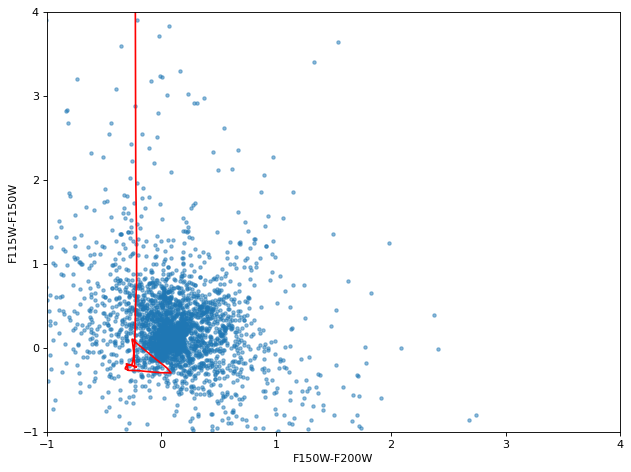

In [38]:
#Overplot model tracks on plot
xcol=(-2.5)*np.log10(t1['F150W']/t1['F200W'])
ycol=(-2.5)*np.log10(t1['F115W']/t1['F150W'])
plot_color_color_tracks('F115W', 'F150W', 'F200W', phot[w], xcol, ycol)

## So now you know how to read in the catalog, plot a color color diagram, and overplot a model track.  You're ready to now complete part 1 of the activity pdf.

[Return to Top](#top)

<a id='pz'></a>
## ONLY AFTER YOU FINISH THE MAIN EXERCISE: Plotting P(z) and Chi^2

Read in the files associated with one of the EAZY runs.

* Photoz_Fiducial: The fiducial results, run on our fiducial fluxes over the full redshift range of 0-20.
* Photoz_Lowz: Run on the fiducial fluxes, with zmax=7.  This is primarily used to visualize the SED of the low-redshift solution.
* Photoz_Circles: Run on fluxes measured in 0.2" diameter apertures.  We use the "FLUX_APERTOT" values, which means that colors are measured in 0.2" diameter circles with the PSF correction applied, and corrected to total with the full aperture correction applied.


In [ ]:
# Specify results of interest
results = 'Fiducial'
resdir = f'/media/home/team_workspaces/JWST-Heidelberg-Summer-School/Lecturers_Area/09_Friday_Session_3/catalogs/'

In [ ]:
# the P(z) and chi^2 arrays for each source are stored in 'ceers_photz_pz_0.1.fits'
tab = Table.read(os.path.join(resdir, 'ceers_photz_pz_0.1.fits'))
                 
# Array of redshifts 
zgrid = tab['ZGRID']

# P(z) for each source
# Take transpose of p(z) from tab to be (nobjs)x(nz)
pz = tab['PZ'].T

# Chi^2 for each source 
# Take transpose of chi^2 from tab to be (nobjs)x(nz)
chi2 = tab['CHI2'].T

# Quantities derived from EAZY results
quantities = Table.read(os.path.join(resdir, 'ceers_photz_quantities_0.1.fits'))

Plot the P(z) and chi^2 distributions for a given source

In [ ]:
def plot_pz_chi2(sourceid):
    """ Make a two panel plot showing the p(z) and chi^2 for a given source ID
    
    Args:
        sourceid (int): ID of source in phot catalog
    """
    # find source in phot catalog
    idx = np.where(phot['ID'] == sourceid)[0][0]

    fig,(ax1,ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11,5))

    # p(z) plot
    ax1.plot(zgrid, pz[idx])
    ax1.fill_between(zgrid, pz[idx], color='C0', alpha=0.5)
    ax1.set_ylim(0, ax1.get_ylim()[1])
    ax1.set_ylabel('P(z)')

    # chi2 plot
    ax2.plot(zgrid, chi2[idx], 'C1')
    ax2.fill_between(zgrid, np.max(chi2[idx]), chi2[idx], color='C1', alpha=0.5)
    ax2.set_ylim(ax2.get_ylim()[0], np.max(chi2[idx]))
    ax2.set_ylabel(r'$\chi^2$')

    for ax in [ax1,ax2]:
        ax.set_xlabel('Redshift')
        ax.set_xlim(0,20)

In [ ]:
plot_pz_chi2(35)

In [ ]:
plot_pz_chi2(10456)

[Return to Top](#top)

<a id='results'></a>
## Printing EAZY Results for Sample

Once you've defined a sample using a set of criteria, print out some photometric redshift quantities for that sample.

In [ ]:
quantities

In [ ]:
# An set of bogus criteria as an example
m277 = -2.5*np.log10(phot['FLUX_F277W']*1.e-9) + 8.9

cond = (m277 < 27) & (quantities['ZA'] > 8) & (quantities['INT_ZGT7'] > 0.6)

In [ ]:
# making a new table using a subset of the columns in quantities, and indexed with cond

# delta chi^2 between best-fitting high-redshift solution and low-redshift solution
delta_chi2 = quantities['CHI2_LOW'] - quantities['CHIA']

sample = Table([quantities['ZA'], quantities['ZL68'], quantities['ZU68'], delta_chi2, 
                quantities['CHIA'], quantities['INT_ZGT8']], 
              names=('ZA','ZL68','ZU68','DELTA_CHI2','CHIA','INT_ZGT8'))
sample = sample[cond]

# formatting floats for easier reading
for col in sample.columns:
    sample[col].format = '{:.3f}'

sample